# Summary

##### **1. Objectives**
Through data exploration, identify complex data structures and shed light on baseline model selection as well as further optimization.
##### **2. EDA Findings & Implication**

| Category | Finding | Implication / Action / Assumption |
| :--- | :--- | :--- |
| **Numeric Variables** | Despite noticeable pairwise correlations, multicollinearity is tolerable for regression (all VIFs < 5). | No feature requires removal solely due to multicollinearity; coefficient estimates should remain numerically stable. |
| | Price correlates nearly linearly with `dim_m2` and especially with `market_volatility`, while most other numeric features show non-linear relationships. | **Assumption:** Purely linear models will underfit these non-linear patterns; tree-based learners are expected to achieve higher accuracy. |
| **Categorical Variables** | Most categories show weak or non-monotonic signal (e.g., `obj_type`, `own_type`, `build_mat`, `cond_class`). | **Action:** Prefer one-hot (or hashing) over target encoding. |
| **Time Variables** | `year_built` follows a dip–rebound pattern; `src_month` rises to **2024-03** then flattens (stable through **2024-06**). | **Assumption:** Recast time features to improve fit and stability:<br>• `house_age_months = 2024-06 − year_built`<br>• `months_since_ref = src_month − 2024-06`<br>Use time-aware validation. |
| **Target Variable** | The target is right-skewed; `log(price_z)` is approximately normal and homoscedastic. | **Assumption:** Train linear baselines on `log(price_z)` to better meet model assumptions. Tree models are less sensitive to skew but still benefit on calibration and metric stability; keep an untransformed baseline for reference. |
| **Feature Set Size & Overfitting Risk** | Spearman analysis flags several features with \|ρ\| < 0.01. | **Assumption:** With **n = 125,163** and **p = 55** (n/p ≈ **2,275**), we are far from typical overfitting thresholds (rule of thumb: ≥10–20 observations per parameter; tipping point ≈ **6,000–12,500** features here). Retaining low-correlation variables is unlikely to harm accuracy. |

# 1. Data Overview

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import ScalarFormatter

# Import from src
from src.data_display import df_display
from src.data_processing import check_missing_data,near_zero_var, compute_vif_table
from src.plot import plot_categorical, plot_time_series, plot_numeric, plot_boxplots,plot_histplots
from src.pipeline_design import evaluate_model,ridge_pipe,elasticnet_pipe,lasso_pipe,svr_rbf_gscv,linear_svr_gscv,xgb_pipe

In [2]:
# lmport data
apartments_train = pd.read_csv("apartments_train.csv")

# Extract the ID column as a standalone Series (use .copy() to decouple from the DataFrame)
id_series = apartments_train['unit_id'].copy()

# Drop the ID column from the training DataFrame to avoid non-informative feature
apartments_train = apartments_train.drop(columns=['unit_id'])

# Dataset Split
df_train, df_test = train_test_split(
    apartments_train,
    test_size=0.2,        #Split ratio: 80% train / 20% test
    random_state=476677,      # Ensure experiment reproducibility by fixing random seeds (NumPy/Python/torch/sklearn)
    shuffle=True
)

In [3]:
# Quick exploratory preview
df_train.shape

(125163, 33)

In [4]:
# Quick exploratory preview
df_display(df_train.head(10))

,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,dist_post,dist_kind,dist_rest,dist_uni,dist_pharma,own_type,build_mat,cond_class,has_park,has_balcony,has_lift,has_sec,has_store,price_z,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
68072,0c238f18,37.91,2,3.00,4.00,1887.00,0.79,117,0.07,0.74,0.15,0.27,0.02,0.43,0.12,12631efb,7ceffe3b,nan,no,yes,no,no,yes,811750.91,Nov-23,378f340c,798229.35,132.96,53.92,55.14,1.00,12.64,96.22
131416,nan,51.91,3,1.00,4.00,2024.00,5.04,4,1.33,2.88,0.59,0.13,0.38,1.80,0.39,12631efb,nan,nan,no,no,nan,no,no,518623.46,Mar-24,e0cff11b,487377.17,0.00,61.90,41.89,1.00,21.77,104.57
76111,0d6c4dfc,58.91,3,7.00,10.00,1970.00,5.21,30,0.16,0.13,0.33,0.14,0.08,1.75,0.02,12631efb,7f8c00f9,nan,no,yes,yes,no,no,462133.54,Oct-23,8d5a4f0c,481812.31,77.06,99.06,41.91,1.00,15.49,92.40
61260,2a6d5c01,57.56,3,nan,3.00,2006.00,6.24,2,0.90,3.55,0.69,0.73,0.51,nan,0.40,12631efb,7ceffe3b,a2881958,yes,no,no,no,no,938555.30,May-24,6900ba06,1038592.06,18.10,51.03,66.94,1.00,18.66,100.58
25598,0d6c4dfc,59.97,3,2.00,4.00,1956.00,0.91,43,0.14,0.12,0.18,0.33,0.07,0.08,0.04,12631efb,nan,53cced8d,yes,no,no,no,yes,826411.72,Apr-24,e0cff11b,699708.59,95.06,16.95,64.74,1.00,14.91,91.82
31028,0c238f18,81.53,4,nan,2.00,1938.00,4.09,55,0.11,0.13,0.20,0.11,0.05,0.44,0.30,12631efb,7ceffe3b,53cced8d,no,yes,no,no,yes,1830053.65,Feb-24,693f303c,2083374.87,126.84,69.49,38.03,1.00,8.21,106.17
46839,0d6c4dfc,27.96,1,9.00,10.00,1980.00,3.35,3,0.52,0.51,0.22,0.76,0.15,2.52,0.55,12631efb,7f8c00f9,nan,no,no,yes,no,yes,521105.40,Aug-23,e0cff11b,449692.91,60.92,73.04,57.59,1.00,13.83,104.61
112278,2a6d5c01,41.59,2,3.00,3.00,2012.00,0.21,142,0.17,0.62,0.06,0.05,0.01,0.56,0.25,12631efb,7ceffe3b,nan,no,yes,yes,yes,no,1312245.74,Nov-23,e0cff11b,1135106.30,10.28,87.87,59.60,1.00,16.94,96.44
116528,0c238f18,74.44,4,1.00,2.00,1910.00,0.46,34,0.04,0.31,0.79,0.24,0.34,0.67,0.16,12631efb,7ceffe3b,nan,no,no,no,no,yes,451021.64,May-24,533f6886,392489.54,102.12,50.81,50.89,1.00,18.29,100.34
56751,0c238f18,97.01,3,1.00,4.00,1903.00,0.64,54,0.12,0.24,0.33,0.48,0.05,0.66,0.20,12631efb,7ceffe3b,nan,no,no,no,no,yes,673442.01,Apr-24,533f6886,699592.36,168.13,80.24,59.27,1.00,31.38,91.53


In [5]:
# Create type-specific preprocessing pipelines
categorical = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'loc_code']
boolean = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
numeric = ['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio', 'estimated_maintenance_cost', 'global_economic_index']
datetime = ['src_month','year_built']


# 2. Data Auditing

In [6]:
# Detect missing values / NaNs in the dataset
df_display(check_missing_data(df_train))

,dtype,count,missing,missing_%
cond_class,object,31513,93650,74.82
build_mat,object,75535,49628,39.65
obj_type,object,98134,27029,21.60
floor_no,float64,103120,22043,17.61
year_built,float64,104628,20535,16.41
infrastructure_quality,float64,104628,20535,16.41
has_lift,object,118948,6215,4.97
dist_uni,float64,121703,3460,2.76
floor_max,float64,123616,1547,1.24
dist_clinic,float64,124726,437,0.35


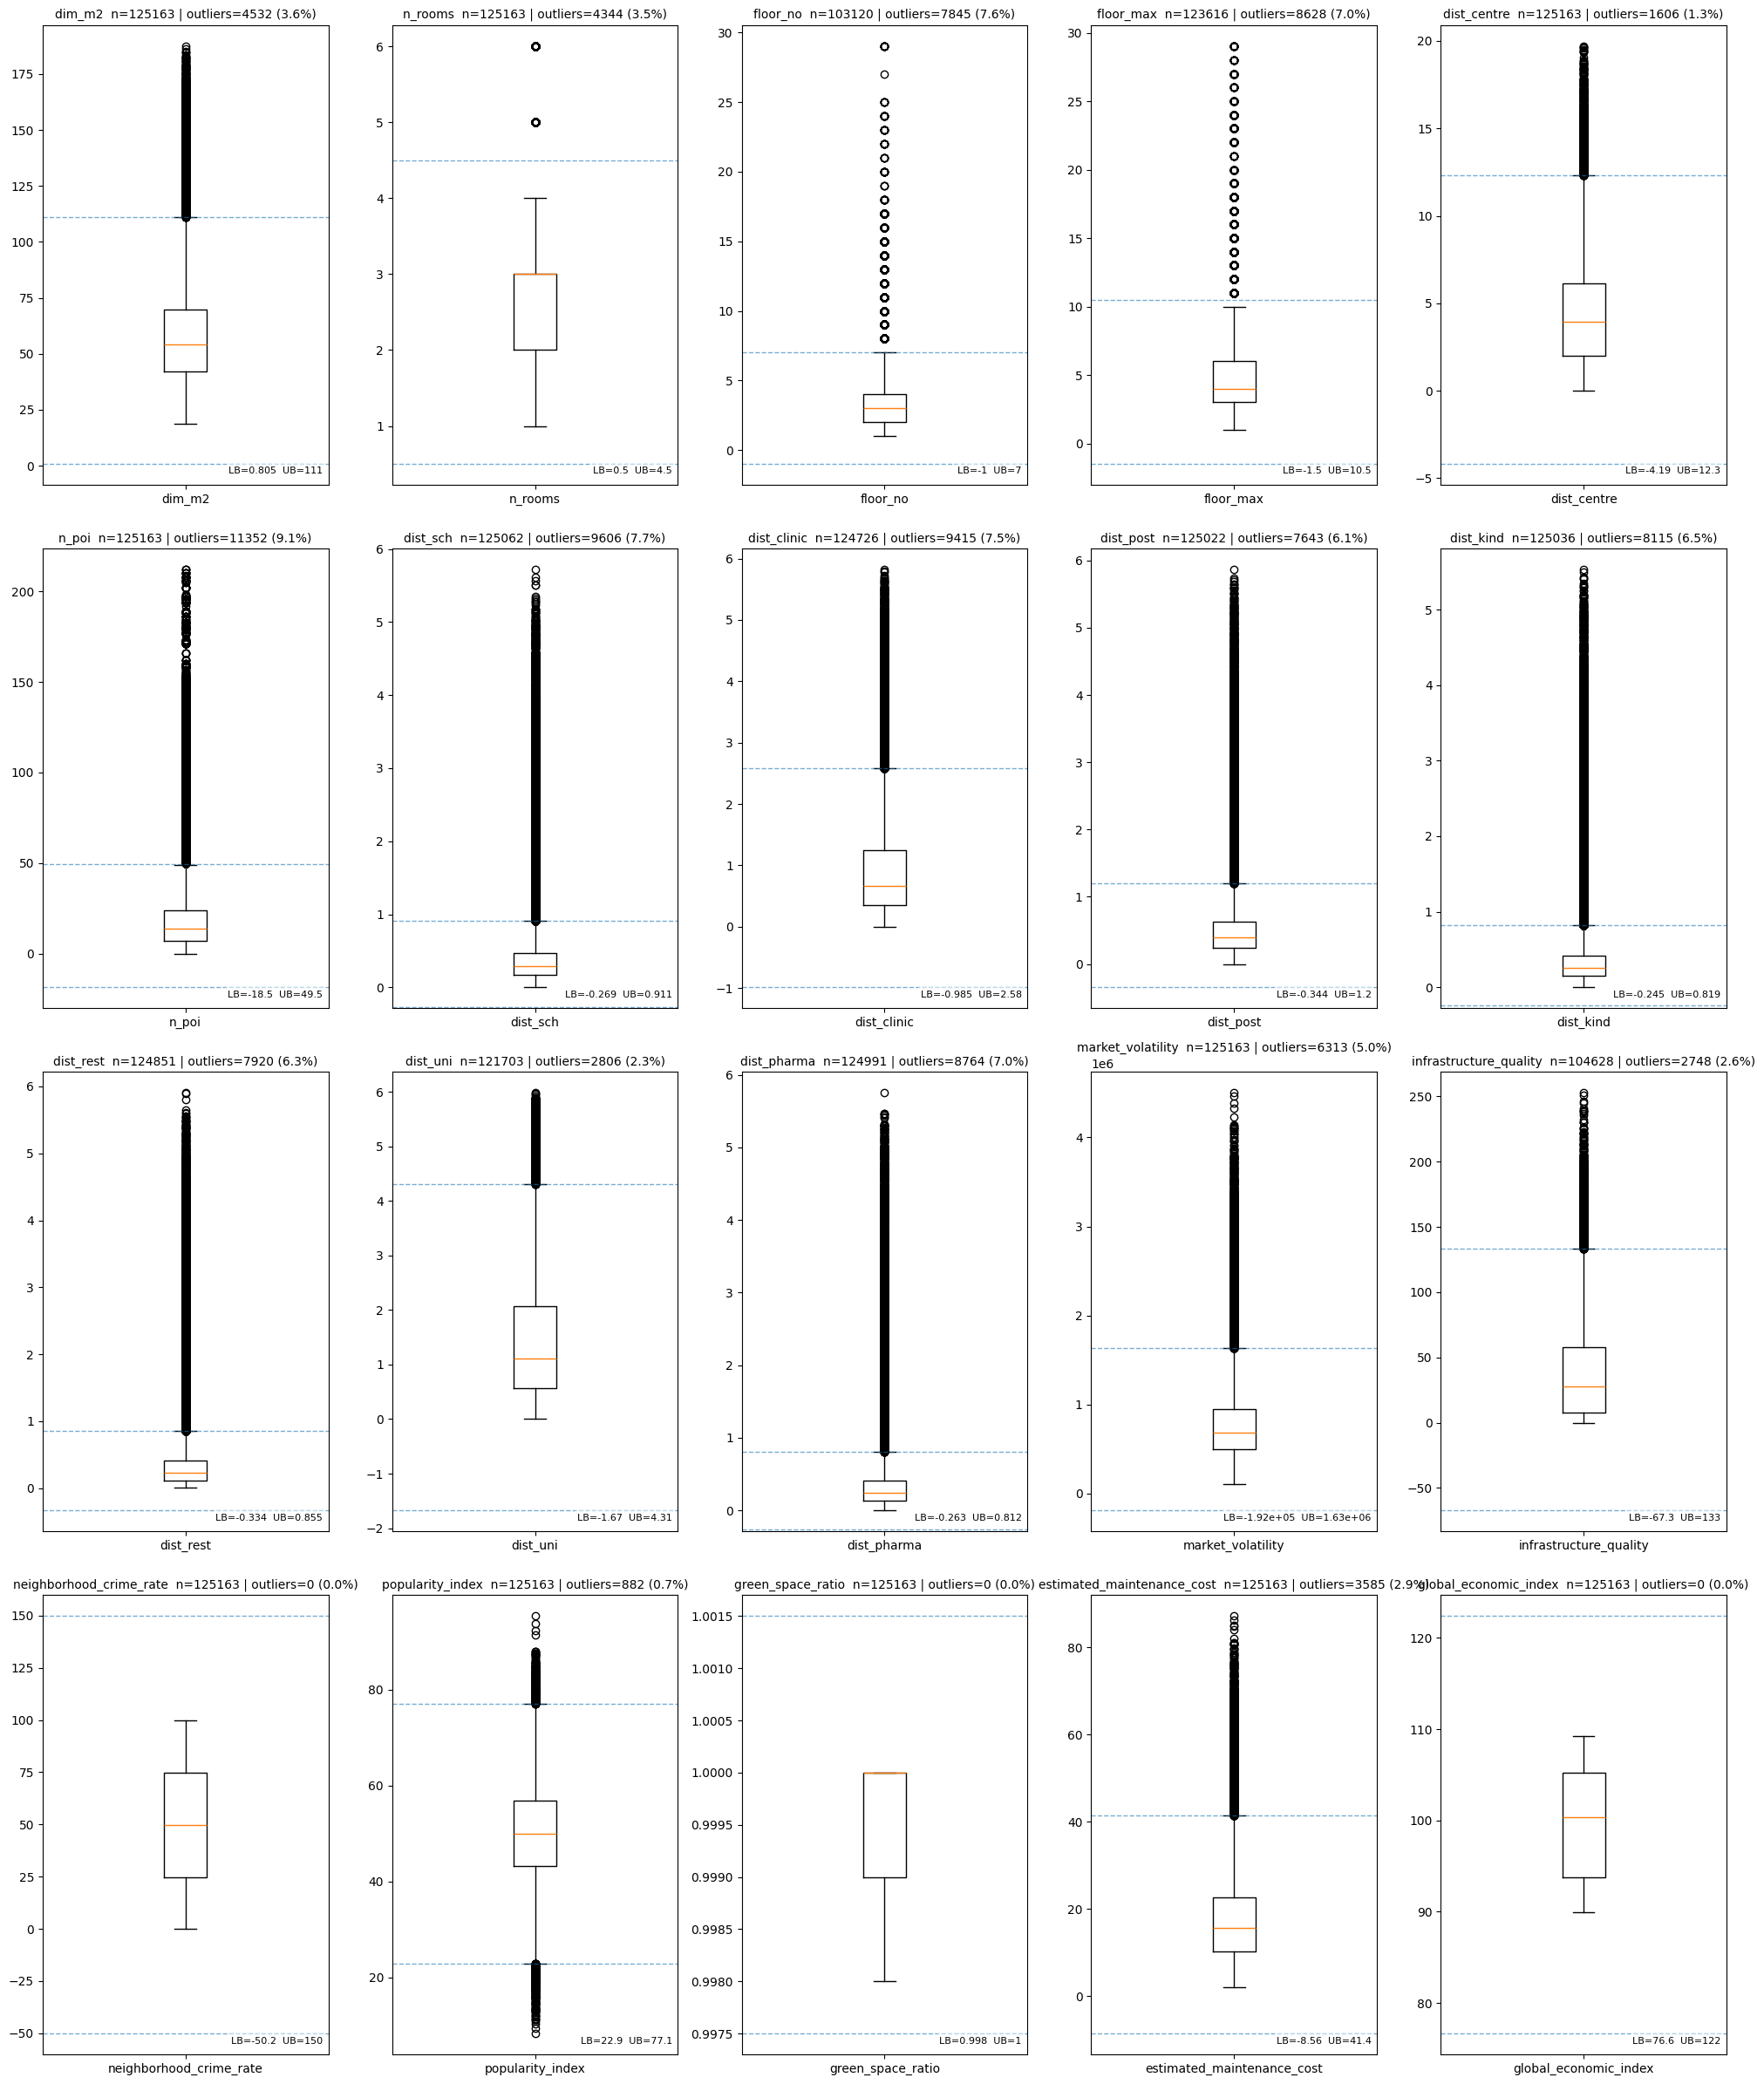

In [7]:
# Detect outliers in continuous variables
fig, axes, corr_df = plot_boxplots(
    df=df_train,
    cols=numeric,            
    n_cols=5,
    figsize_per_chart=(4, 6),
    annotate=True,
    save_png=False,
    jitter=0.0
)

plt.show()

# 3. Data Exploration

## 1. Numeric Variables

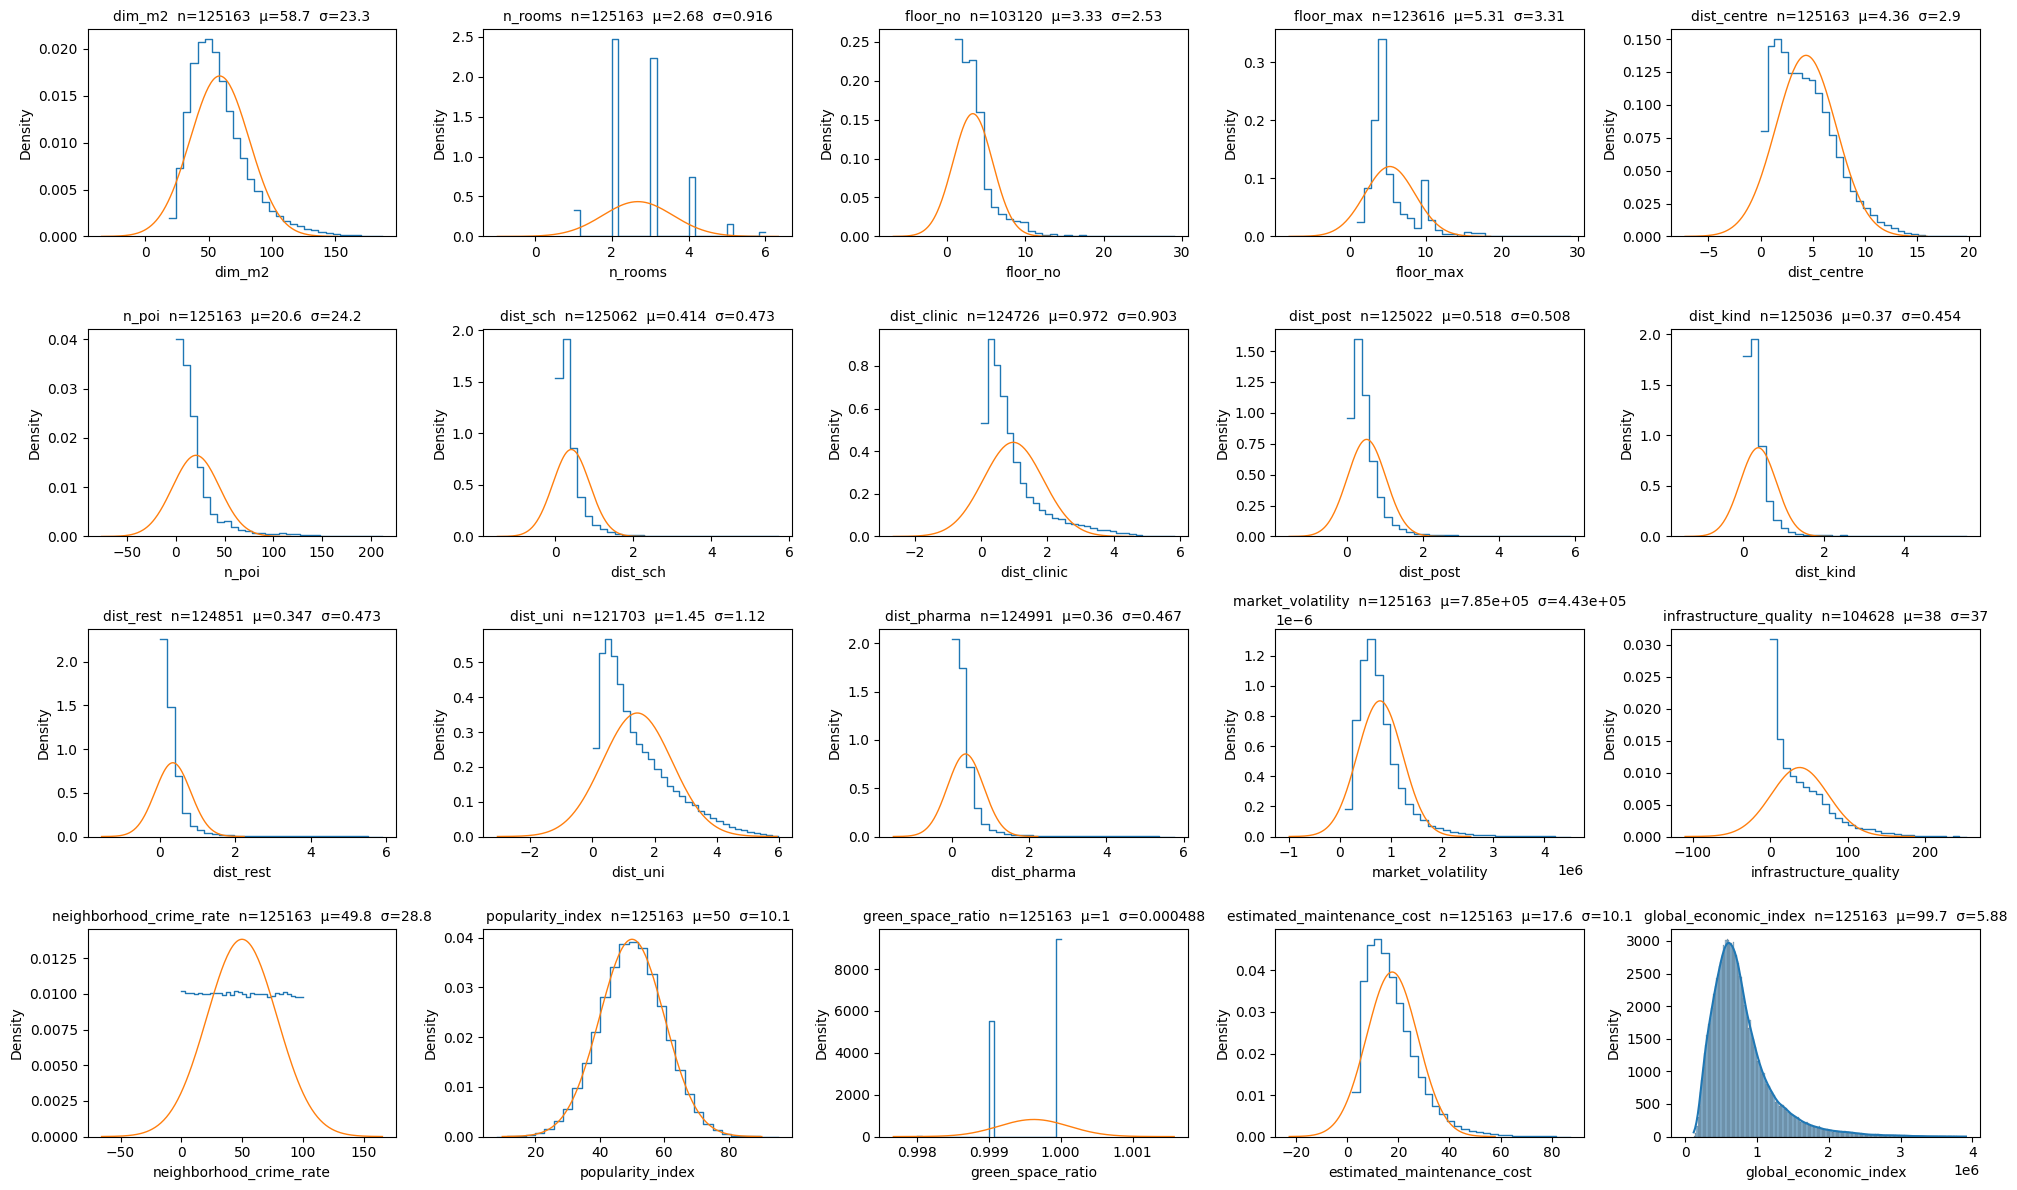

In [8]:
# Visualize distributions in continuous variables
fig, axes, corr_df = plot_histplots(
    df=df_train,
    cols=numeric,
    n_cols=5,
    figsize_per_chart=(4, 3),
    bins=30,       
    kde=False      
)


sns.histplot(df_train["price_z"],
             kde = True)

plt.show()

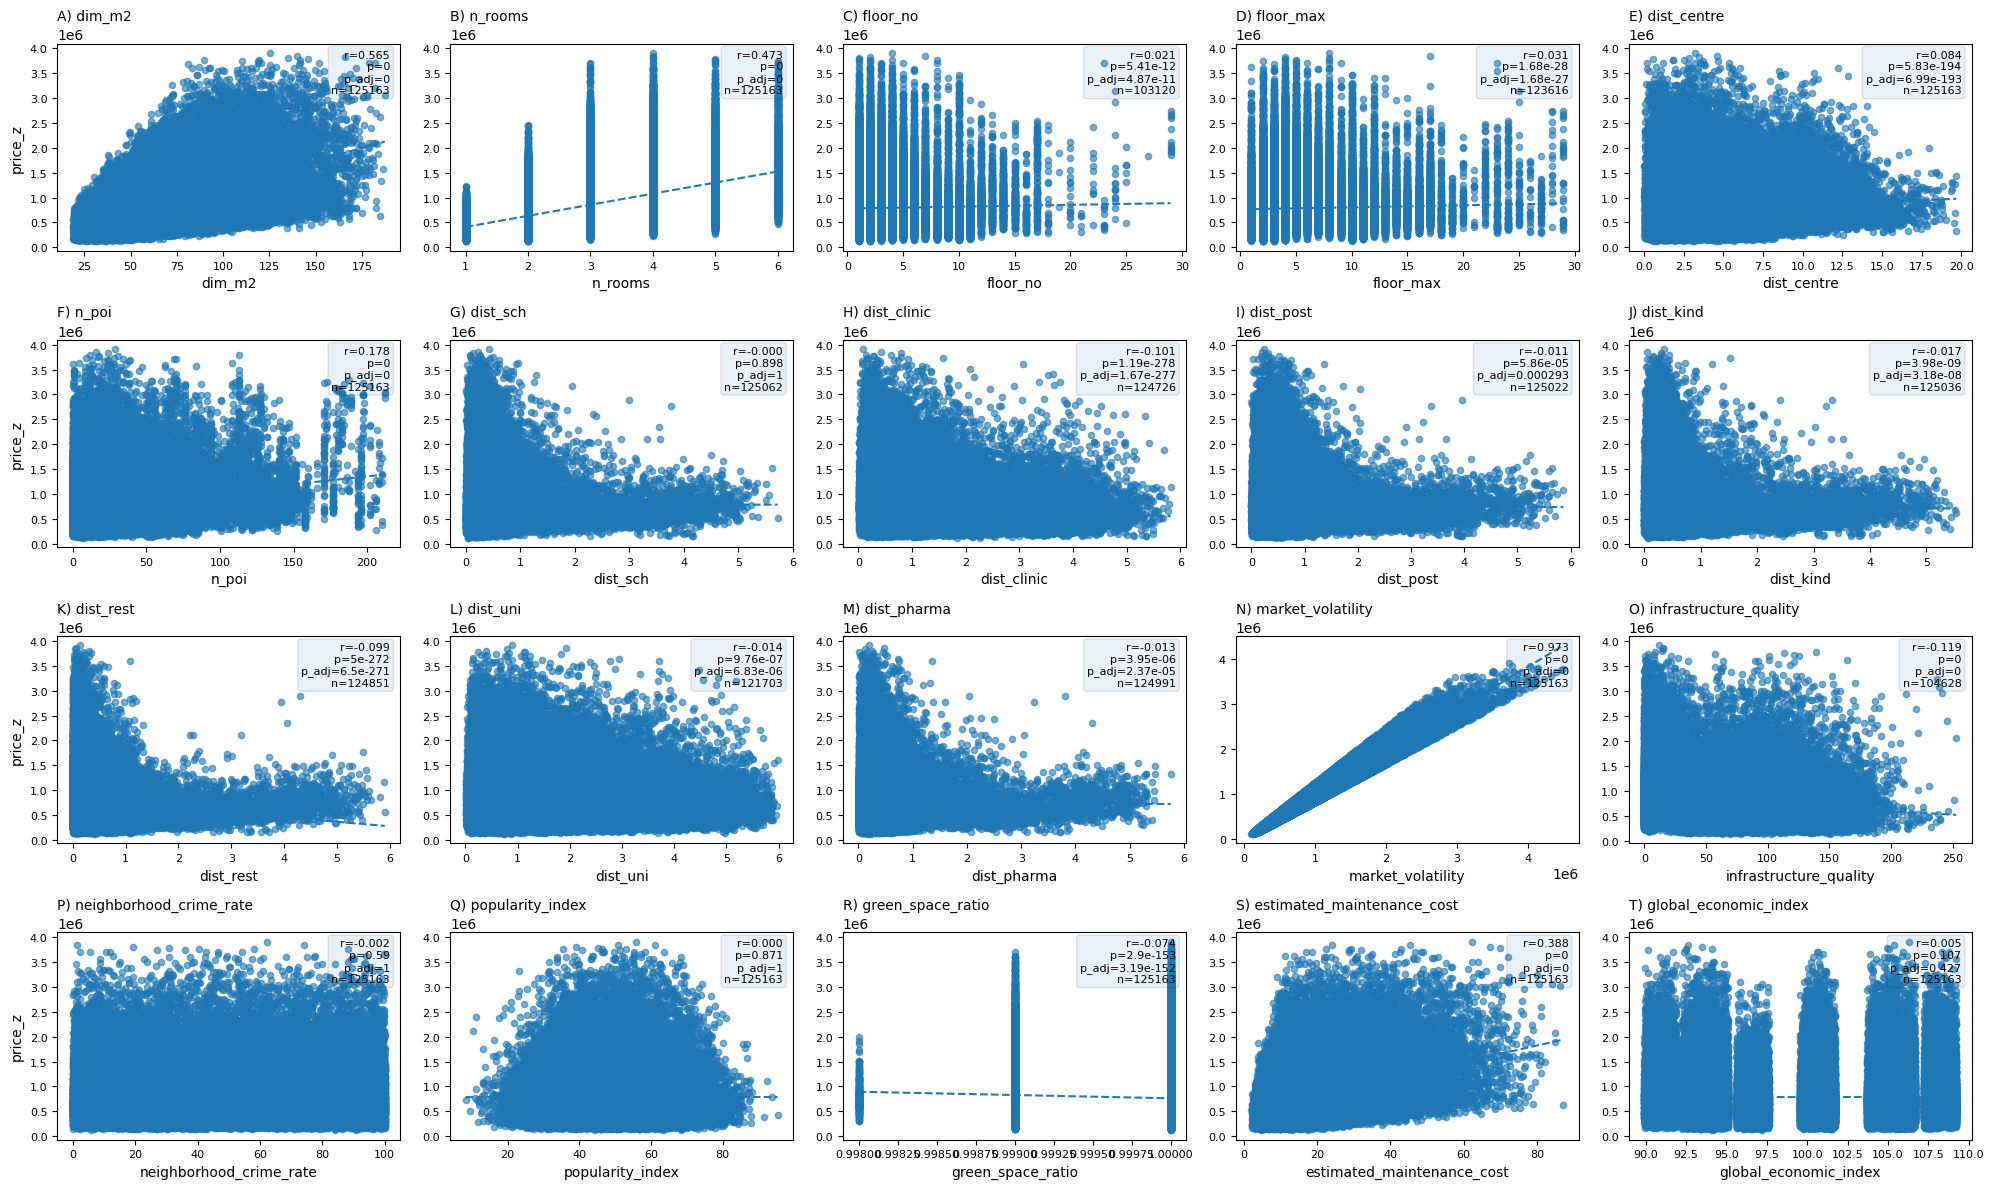

In [9]:
# Visualize relationships between numeric features and the target variable
fig, axes, corr_df = plot_numeric(
    df=df_train,
    value_col='price_z',
    cols=numeric,
    n_cols=5,
    figsize_per_chart=(4, 3),
    annotate=True,
    p_adjust_method='holm',
    save_png=False,
    add_regression=True,
    jitter=0.0
)

plt.show()

<Axes: >

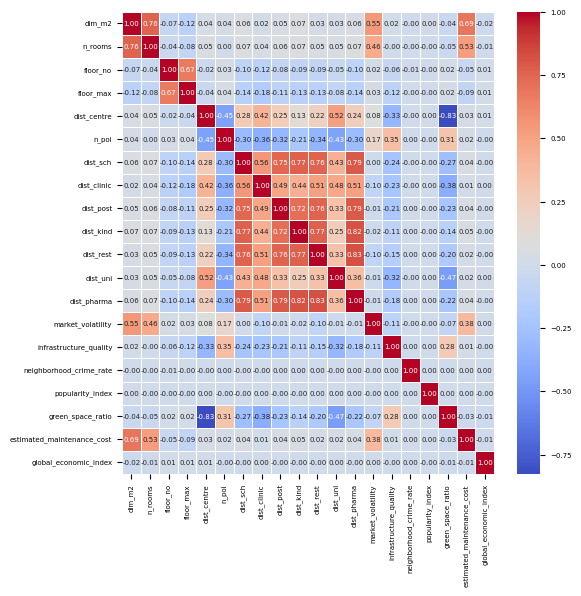

In [10]:
# Compute correlation matrix, handling missing data (NaN)
appartments_correlations = df_train[numeric].corr(method = 'pearson')

# It is better to look at graphical representation of correlation matrix
plt.figure(figsize=(6, 6))
plt.rc('font', size=5)

sns.heatmap(appartments_correlations,
            annot = True,
            cmap = "coolwarm",
            fmt = ".2f",
            linewidths = 0.5)

In [11]:
# Multicollinearity Detection
# 1) Compute and view the VIF table for the selected numeric predictors
vif_table = compute_vif_table(df_train, features=numeric, dropna=True)

# 2) Print the VIF results
df_display(vif_table)

,VIF,n_obs,VIF_gt_5,VIF_gt_10
feature,,,,
dist_centre,3.72,83908,False,False
dim_m2,3.70,83908,False,False
dist_pharma,3.38,83908,False,False
green_space_ratio,3.18,83908,False,False
dist_rest,2.78,83908,False,False
dist_sch,2.74,83908,False,False
dist_kind,2.61,83908,False,False
n_rooms,2.43,83908,False,False
dist_post,2.35,83908,False,False


## 2. Categorical Variables

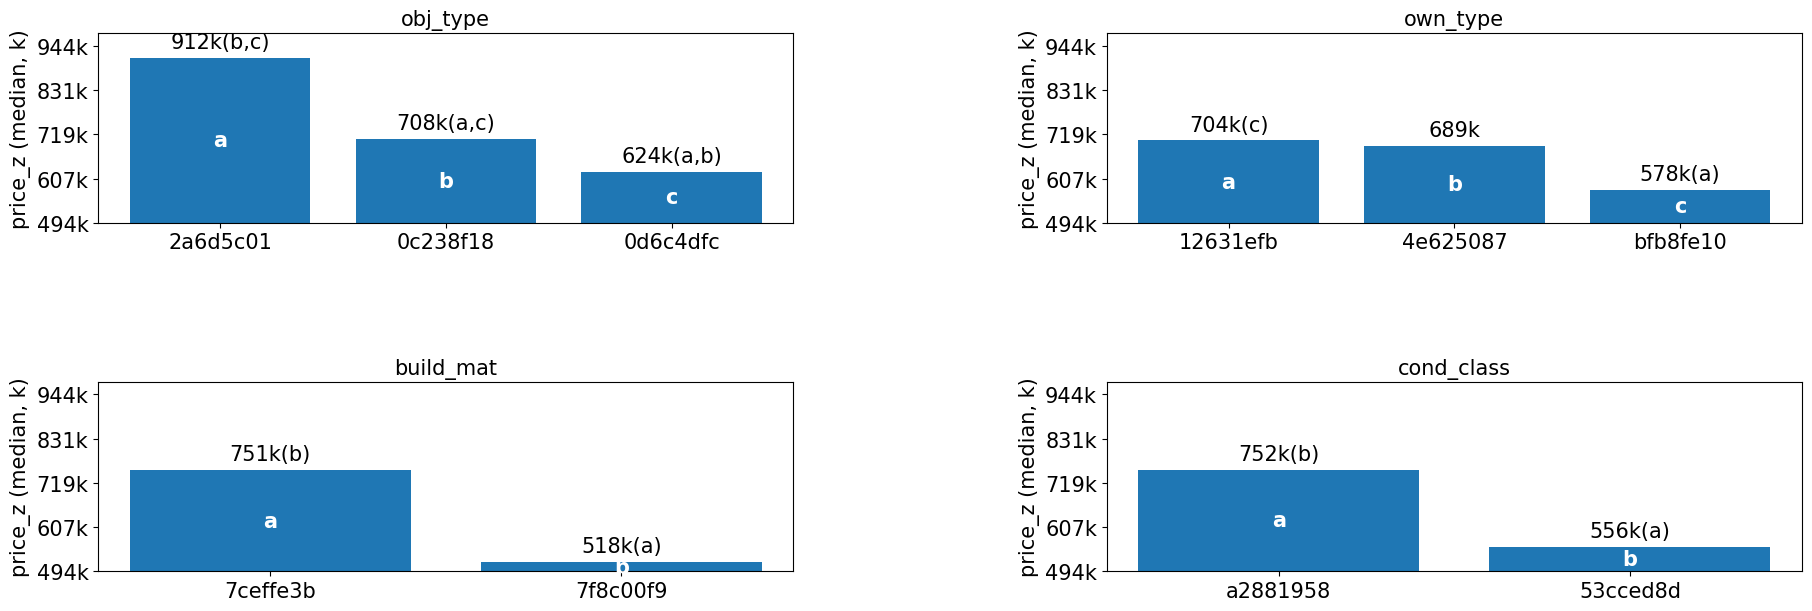

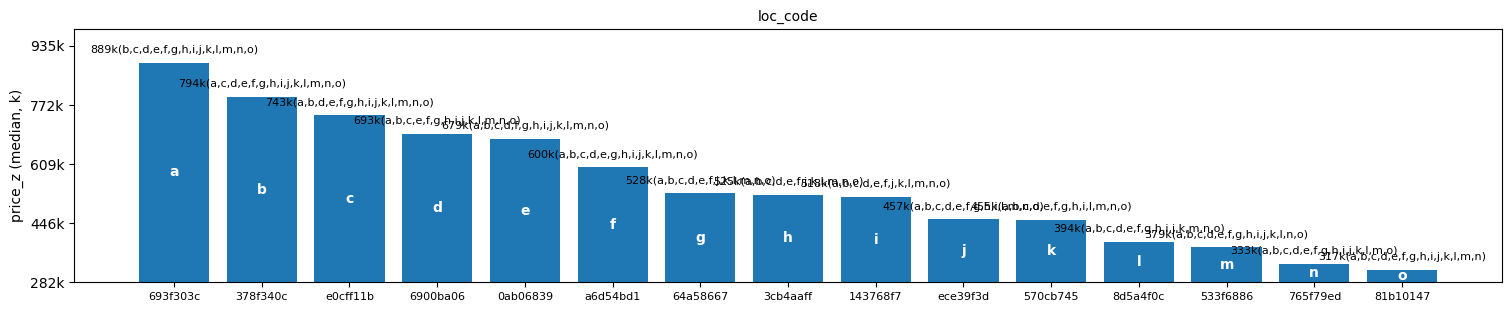

In [12]:
# Visualize relationships between categorical features and the target variable
plot_categorical(
    df=df_train, value_col='price_z',
    cols=categorical[:-1],
    n_cols=2, figsize_per_chart=(3, 3),
    sort_by_count=False, annotate=True,
    alpha=0.05, p_adjust_method='holm',  # Multiple-testing correction method (options: 'bonferroni', 'fdr_bh', 'none')
    save_png=False,
    title_fontsize=15, label_fontsize=15,
    xtick_fontsize=15, annotation_fontsize=15, main_letter_fontsize=15,
)

plot_categorical(
    df=df_train, value_col='price_z',
    cols=['loc_code'],
    n_cols=1, figsize_per_chart=(1, 3),
    sort_by_count=False, annotate=True,
    alpha=0.05, p_adjust_method='holm', 
    save_png=False,
    title_fontsize=10, label_fontsize=10,
    xtick_fontsize=8, annotation_fontsize=8, main_letter_fontsize=10,
)

plt.show()

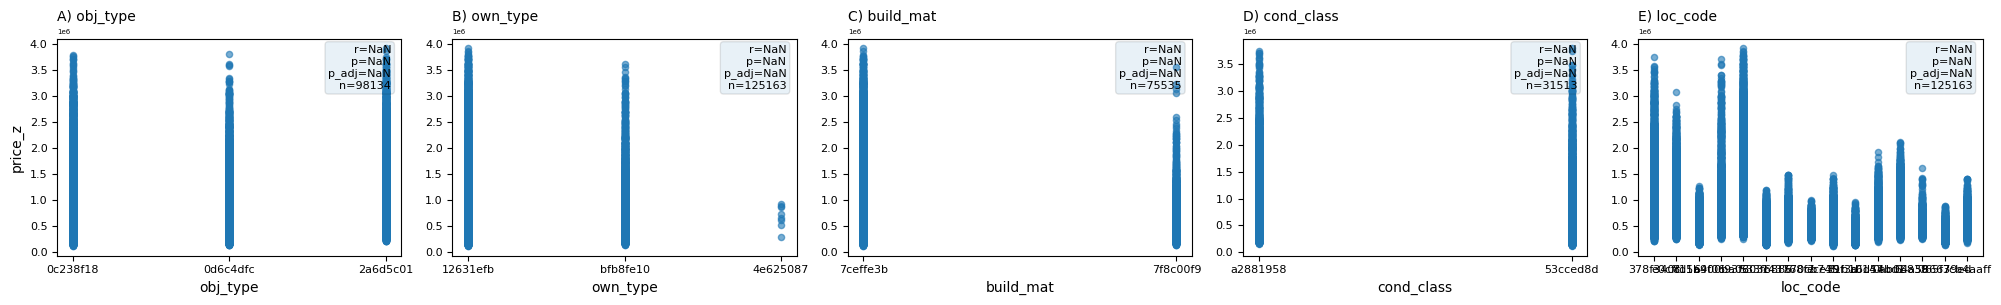

In [13]:
# Visualize relationships between categorical features and the target variable
fig, axes, corr_df = plot_numeric(
    df=df_train,
    value_col='price_z',
    cols=categorical,
    n_cols=5,
    figsize_per_chart=(4, 3),
    annotate=True,
    p_adjust_method='holm',
    save_png=False,
    add_regression=True,
    jitter=0.0
)

plt.show()

## 3. Boolean Variables

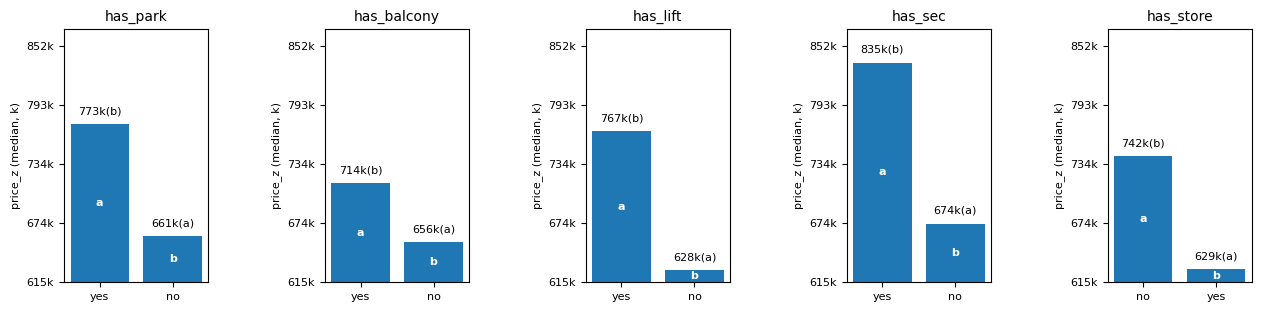

In [14]:
# Visualize relationships between boolean features and the target variable
plot_categorical(
    df=df_train, value_col='price_z',
    cols=boolean,  
    n_cols=5, figsize_per_chart=(0.5, 3),
    sort_by_count=False, annotate=True,
    alpha=0.05, p_adjust_method='holm',
    save_png=False,
    title_fontsize=10, label_fontsize=8,
    xtick_fontsize=8, annotation_fontsize=8, main_letter_fontsize=8,
)

plt.show()

## 4. Time Variables

In [15]:
# Parse source month strings to datetime (invalid parsing becomes NaT), 
# then convert to YYYYMM integer format while preserving missing values as NaN, finally cast to nullable integer type
s = pd.to_datetime(df_train['src_month'], format='%b-%y', errors='coerce')
df_train['src_month'] = (s.dt.year * 100 + s.dt.month).where(s.notna()).astype('Int64')

# Cast 'year_built' to pandas nullable integer dtype so missing values are preserved as <NA>.
df_train['year_built'] = df_train['year_built'].astype('Int64').round()

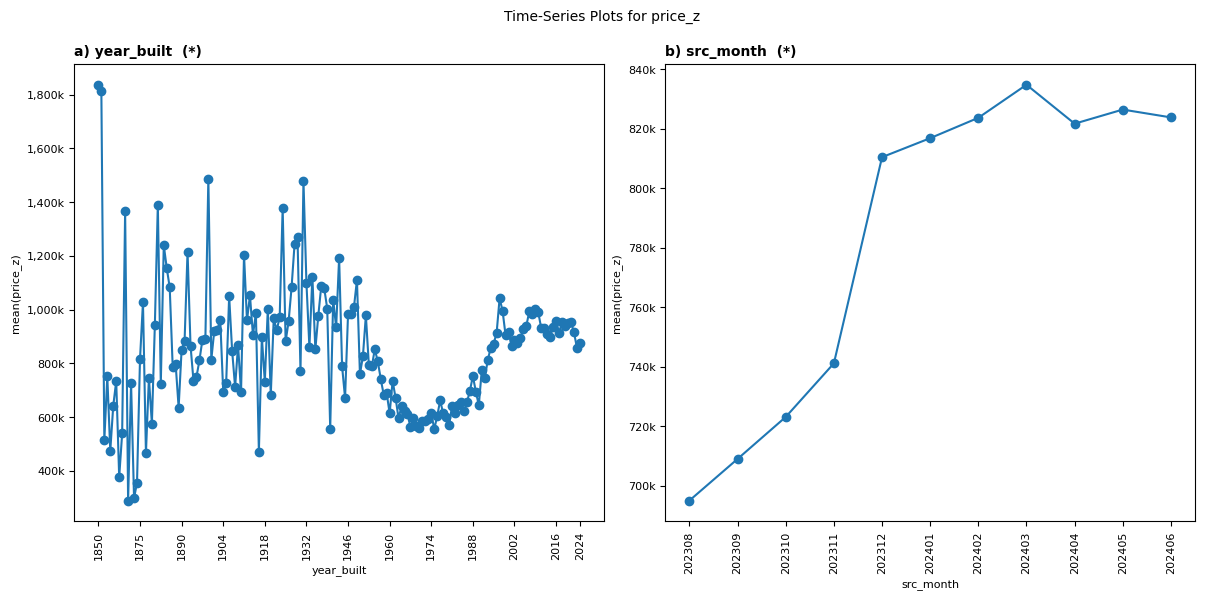

In [16]:
# Visualize relationships between time features and the target variable
plot_time_series(
    df=df_train,
    value_col='price_z',
    cols=['year_built','src_month'],
    n_cols=2,                     
    figsize_per_chart=(6, 6),     
    sort_by_count=False,         
    annotate=False,               
    save_png=False,
)

plt.show()

## 5. Target Variable

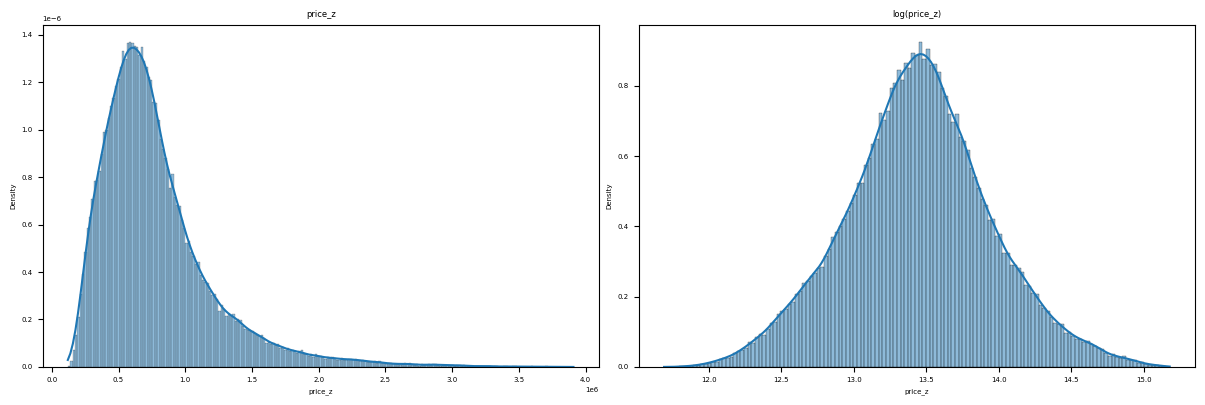

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

sns.histplot(df_train['price_z'], kde=True, stat="density", ax=axes[0])
axes[0].set_title("price_z")

sns.histplot(np.log(df_train['price_z']), kde=True, stat="density", ax=axes[1])
axes[1].set_title("log(price_z)")

plt.tight_layout()
plt.show()

In [19]:
# Calculate Spearman correlation coefficients between all numeric features and the target variable 'price_z'
corr_with_pricez = df_train[numeric].corrwith(df_train['price_z'], method='spearman')

# Sort the correlations by absolute value in descending order and round to 2 decimal places
corr_with_pricez_sorted = (
    corr_with_pricez.sort_values(key=lambda s: s.abs(), ascending=False).round(2)
)
print(corr_with_pricez_sorted)

market_volatility             0.97
dim_m2                        0.51
n_rooms                       0.45
estimated_maintenance_cost    0.33
infrastructure_quality       -0.22
dist_rest                    -0.16
green_space_ratio            -0.13
dist_centre                   0.13
dist_clinic                  -0.12
n_poi                         0.10
dist_sch                      0.06
floor_max                     0.05
dist_post                     0.02
dist_uni                      0.01
dist_pharma                   0.01
floor_no                     -0.01
global_economic_index         0.00
neighborhood_crime_rate      -0.00
dist_kind                    -0.00
popularity_index             -0.00
dtype: float64
